# Laboratório 1: Iteração de valor

## Importações

In [1]:
# Importações
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import seaborn as sns
from typing import Dict, Tuple, List, Union, Optional, Set

## Ambiente: Navegação no Labirinto (gridworld)

In [2]:
# Ambiente: Navegação no Labirinto (gridworld)
class AmbienteNavegacaoLabirinto:
    """
    Navegação no Labirinto (gridworld) determinístico para experimentos de aprendizado por reforço.

    Política de recompensa:
    - A recompensa é calculada com base na tentativa de movimento (s, a -> posição proposta), antes de aplicar rebote por sair da grade ou por entrada proibida em bad_states.
    - Se a tentativa mira fora da grade: r_boundary
    - Se mira um bad_state: r_bad
    - Se mira um target_state: r_target
    - Caso contrário: r_other

    Terminação:
    - Por padrão, o ambiente não encerra episódios automaticamente (target_states/bad_states não são estados terminais).
    """

    def __init__(
        self,
        world_size: Tuple[int, int],
        bad_states: List[Tuple[int, int]],
        target_states: List[Tuple[int, int]],
        allow_bad_entry: bool = False,
        rewards: Optional[List[float]] = None
    ) -> None:
        """
        Inicializa o ambiente de navegação em labirinto.

        Parâmetros
        ----------
        world_size : (n_linhas, n_colunas)
            Dimensões da grade.
        bad_states : lista de (linha, coluna)
            Coordenadas dos estados com penalidade.
        target_states : lista de (linha, coluna)
            Coordenadas dos estados-alvo.
        allow_bad_entry : bool
            Se False, impede entrada em bad_states (rebote para o estado atual).
        rewards : [r_boundary, r_bad, r_target, r_other]
            Recompensas possíveis. Se None, usa [-1, -1, 1, 0].
        """
        if rewards is None:
            rewards = [-1, -1, 1, 0]

        self.n_rows, self.n_cols = world_size   # dimensões da grade do labirinto
        self.bad_states = set(bad_states)       # estados com penalidade alta
        self.target_states = set(target_states) # estados com recompensa alta
        self.allow_bad_entry = allow_bad_entry  # se o agente pode entrar em estados ruins

        # Validações
        for st in self.bad_states | self.target_states:
            if not (0 <= st[0] < self.n_rows and 0 <= st[1] < self.n_cols):
                raise ValueError(f"Estado {st} fora dos limites.")
        if self.bad_states & self.target_states:
            raise ValueError("bad_states e target_states devem ser disjuntos.")

        # Recompensas definidas para cada tipo de transição
        self.r_boundary = rewards[0]    # tentar sair da grade
        self.r_bad      = rewards[1]    # transição para estado ruim
        self.r_target   = rewards[2]    # transição para estado alvo
        self.r_other    = rewards[3]    # demais transições

        # Espaço de ações: dicionário com deslocamentos (linha, coluna)
        self.action_space = {
            0: (-1, 0),  # cima
            1: (1, 0),   # baixo
            2: (0, -1),  # esquerda
            3: (0, 1),   # direita
            4: (0, 0)    # permanecer no mesmo estado
        }

        # Espaço de recompensas: lista de recompensas possíveis
        self.recompensas_possiveis = np.array(sorted(set(rewards)))
        self.reward_map = {r: i for i, r in enumerate(self.recompensas_possiveis)}

        # número total de estados
        self.n_states = self.n_rows * self.n_cols

        # número total de ações
        self.n_actions = len(self.action_space)

        # número total de recompensas possíveis
        self.n_rewards = self.recompensas_possiveis.shape[0]

        # Tensor de probabilidades de transição: P(s'|s,a)
        self.state_transition_probabilities = np.zeros((self.n_states, self.n_states, self.n_actions))

        # Tensor de probabilidade de recompensas: P(r|s,a)
        self.reward_probabilities = np.zeros((self.n_rewards, self.n_states, self.n_actions))

        # Matriz de recompensa imediata (determinística): recompensa[s, a] = r
        self.recompensas_imediatas = np.zeros((self.n_states, self.n_actions))

        # Matriz de transição de estados (determinística): transicao[s, a] = s'
        self.transicao_de_estados = np.zeros((self.n_states, self.n_actions), dtype=int)

        self.agent_pos = (0, 0)  # posição inicial do agente

        self._init_dynamics()  # inicializa as dinâmicas de transição e recompensa


    def __repr__(self) -> str:
        return (f"AmbienteNavegacaoLabirinto({self.n_rows}x{self.n_cols}, "
                f"bad={len(self.bad_states)}, target={len(self.target_states)}, "
                f"allow_bad_entry={self.allow_bad_entry}, agent_pos={self.agent_pos})")


    def __str__(self) -> str:
        return self.render(as_string=True)


    def reset(self) -> Tuple[int, int]:
        """
        Reinicia a posição do agente para o estado inicial (0, 0).

        Retorna
        -------
        (linha, coluna) : posição inicial do agente.
        """
        self.agent_pos = (0, 0)
        return self.agent_pos


    def step(self, acao: int, *, linear: bool = False) -> Tuple[Union[int, Tuple[int, int]], float]:
        """
        Executa uma ação, atualiza a posição do agente e devolve o próximo estado.

        Parâmetros
        ----------
        acao : int
            Índice da ação (0-4).
        linear : bool, keyword-only (default=False)
            Se True, retorna o estado como índice linear {0,...,self.n_states-1}; caso contrário, retorna tupla (linha, coluna).

        Retorna
        -------
        proximo_estado : int | (int, int)
            Estado observado após a transição (com possível rebote).
        recompensa : float
            Recompensa imediata recebida.
        """
        estado_atual = self.agent_pos                                           # armazena o estado atual do agente
        proposta = self._proposta(estado_atual, acao)                           # calcula a posição proposta pela ação
        recompensa = self._compute_reward(proposta)                             # avalia a recompensa com base na tentativa
        destino = self._destino_final(estado_atual, acao)                       # aplica regras e obtém o destino após possíveis rebotes
        self.agent_pos = destino                                                # atualiza a posição interna do agente
        proximo_estado = self.state_to_index(destino) if linear else destino    # escolhe o formato da observação de saída
        return proximo_estado, recompensa                                       # retorna observação e recompensa


    def reset_to_state(self, estado: Union[Tuple[int, int], int], verificar_validade_estado: bool = True) -> Tuple[int, int]:
        """
        Teleporta o agente para `estado` sem reiniciar o episódio completo.

        Parâmetros
        ----------
        estado : (linha, coluna) | int
            Tupla de coordenadas (linha, coluna) ou índice linear (int).
        verificar_validade_estado : bool
            Se True, lança ValueError se o estado for inválido.

        Retorna
        -------
        (linha, coluna) : nova posição do agente.
        """
        # Converte índice -> tupla, se necessário
        if isinstance(estado, int):
            estado = self.index_to_state(estado)

        if verificar_validade_estado and not self._in_bounds(estado):
            raise ValueError(f"Estado {estado} fora dos limites do labirinto.")

        self.agent_pos = tuple(estado)      # mantém tupla imutável

        return self.agent_pos


    def is_bad(self, state: Union[int, Tuple[int, int]]) -> bool:
        """Retorna True se o estado for um bad_state."""
        if isinstance(state, int):
            state = self.index_to_state(state)
        return state in self.bad_states


    def is_target(self, state: Union[int, Tuple[int, int]]) -> bool:
        """Retorna True se o estado for um target_state."""
        if isinstance(state, int):
            state = self.index_to_state(state)
        return state in self.target_states


    def state_to_index(self, estado: Tuple[int, int]) -> int:
        """
        Converte coordenada (linha, coluna) para índice linear no intervalo [0, n_states-1].
        """
        linha, coluna = estado
        return linha * self.n_cols + coluna


    def index_to_state(self, indice: int) -> Tuple[int, int]:
        """
        Converte índice linear  no intervalo [0, n_states-1] para coordenada (linha, coluna).
        """
        return divmod(indice, self.n_cols)  # (linha, coluna) = (indice // self.n_cols, indice % self.n_cols)


    def enumerate_states(self) -> List[int]:
        """Retorna a lista de índices lineares de todos os estados [0, ..., n_states - 1]."""
        return list(range(self.n_states))


    def enumerate_actions(self) -> List[int]:
        """Retorna a lista de índices das ações disponíveis [0, ..., n_actions - 1]."""
        return list(self.action_space.keys())


    def render(
        self,
        *,
        as_string: bool = True,
        show_coords: bool = False,
        legend: bool = True,
        chars: dict | None = None
    ) -> str:
        """
        Renderização ASCII do grid.
        - A: agente, B: bad, T: target, .: vazio
        - show_coords: mostra índices de linha/coluna
        - legend: inclui legenda ao final
        - chars: permite customizar símbolos (keys: 'agent','bad','target','empty')
        """
        if chars is None:
            chars = {"agent": "A", "bad": "B", "target": "T", "empty": "."}

        linhas = []

        # cabeçalho de colunas
        if show_coords:
            header = "    " + " ".join(f"{c:2d}" for c in range(self.n_cols))
            linhas.append(header)
            linhas.append("    " + "--" * self.n_cols)

        # monta o grid linha a linha
        for r in range(self.n_rows):
            row_syms = []
            for c in range(self.n_cols):
                sym = chars["empty"]
                if (r, c) in self.bad_states:
                    sym = chars["bad"]
                if (r, c) in self.target_states:
                    sym = chars["target"]
                if self.agent_pos == (r, c):
                    sym = chars["agent"]
                row_syms.append(sym)

            linha_str = " ".join(row_syms)
            if show_coords:
                linhas.append(f"{r:2d} | {linha_str}")
            else:
                linhas.append(linha_str)

        # legenda
        if legend:
            linhas.append("")
            linhas.append(f"Legenda: {chars['agent']}=agente, {chars['bad']}=bad, "
                        f"{chars['target']}=target, {chars['empty']}=vazio")

        out = "\n".join(linhas)
        return out if as_string else print(out)


    def plot_labirinto(self, ax=None, titulo: str = "Visualização do Labirinto", cbar: bool = False):
        """
        Visualiza o labirinto.

        Representa:
        - Estado neutro: branco
        - Estado ruim: vermelho
        - Estado alvo: verde

        Parâmetros
        ----------
        ax : matplotlib.axes.Axes, opcional
            Eixo onde desenhar. Se None, cria uma nova figura.
        titulo : str, opcional
            Título do gráfico.
        cbar : bool, opcional (default=False)
            Exibe (True) ou oculta (False) a barra de cores.

        Retorna
        -------
        ax : matplotlib.axes.Axes
            Eixo com o heatmap.
        """
        # Cria matriz com valores padrão (0 = neutro)
        matriz = np.zeros((self.n_rows, self.n_cols), dtype=int)

        # marca estados
        for (r, c) in self.bad_states:
            matriz[r, c] = 1   # ruim
        for (r, c) in self.target_states:
            matriz[r, c] = 2   # alvo

        # cores: branco=neutro, vermelho=ruim, verde=alvo
        cmap = ListedColormap(["white", "red", "green"])

        fig = None
        if ax is None:
            fig, ax = plt.subplots(figsize=(self.n_cols, self.n_rows))

        ax = sns.heatmap(
            matriz,
            cmap=cmap,
            cbar=cbar,
            linewidths=0.5,
            linecolor="gray",
            square=True,
            ax=ax
        )

        # remove ticks/labels
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_xticklabels([]); ax.set_yticklabels([])

        # bordas externas
        for side in ("left", "right", "top", "bottom"):
            ax.spines[side].set_visible(True)
            ax.spines[side].set_linewidth(0.5)
            ax.spines[side].set_edgecolor("gray")

        ax.set_title(titulo)

        if fig is not None:
            plt.tight_layout()
            plt.show()

        return


    def _init_dynamics(self):
        """
        Preenche as matrizes de transição e recompensa com base na estrutura do ambiente e regras de movimentação.
        """

        self.recompensas_imediatas.fill(0.0)
        self.transicao_de_estados.fill(0)
        self.state_transition_probabilities.fill(0.0)
        self.reward_probabilities.fill(0.0)

        for s in self.enumerate_states():                                   # percorre todos os estados (índices lineares)
            estado_atual = self.index_to_state(s)                           # converte índice para (linha, coluna)
            for a in self.enumerate_actions():                              # percorre todas as ações disponíveis
                proposta = self._proposta(estado_atual, a)                  # calcula a posição proposta pela ação
                r = self._compute_reward(proposta)                          # avalia a recompensa da tentativa de movimento
                destino = self._destino_final(estado_atual, a)              # obtém destino após aplicar regras de rebote
                s_next = self.state_to_index(destino)                       # converte destino para índice linear

                self.recompensas_imediatas[s, a] = r                        # registra r(s, a) na matriz de recompensas imediatas
                self.transicao_de_estados[s, a] = s_next                    # registra T(s, a) = s' na matriz de transições

                self.state_transition_probabilities[s_next, s, a] = 1.0     # define P(s'|s, a) = 1 (ambiente determinístico)
                self.reward_probabilities[self.reward_map[r], s, a] = 1.0   # define P(r |s, a) = 1 (ambiente determinístico)


    def _proposta(self, state: Tuple[int, int], acao: int) -> Tuple[int, int]:
        """Retorna a posição proposta (antes de qualquer rebote)."""
        dl, dc = self.action_space[acao]
        return (state[0] + dl, state[1] + dc)


    def _destino_final(self, state: Tuple[int, int], acao: int) -> Tuple[int, int]:
        """
        Aplica as regras de rebote: fora da grade => rebote;
        bad_state com allow_bad_entry=False => rebote; caso contrário segue para a proposta.
        """
        proposta = self._proposta(state, acao)
        if not self._in_bounds(proposta):
            return state
        if (not self.allow_bad_entry) and self.is_bad(proposta):
            return state
        return proposta


    def _in_bounds(self, posicao: Tuple[int, int]) -> bool:
        """
        Verifica se uma posição está dentro dos limites do labirinto.

        Parâmetros
        ----------
        posicao : (linha, coluna)

        Retorna
        -------
        bool : True se dentro da grade, False caso contrário.
        """
        linha, coluna = posicao
        return 0 <= linha < self.n_rows and 0 <= coluna < self.n_cols


    def _compute_reward(self, destino: Tuple[int, int]) -> float:
        """
        Calcula a recompensa da tentativa de transição para 'destino'.

        Regras
        ------
        - Se 'destino' está fora da grade: r_boundary
        - Se 'destino' é bad_state: r_bad
        - Se 'destino' é target_state: r_target
        - Caso contrário: r_other
        """
        if not self._in_bounds(destino):
            return self.r_boundary
        elif self.is_bad(destino):
            return self.r_bad
        elif self.is_target(destino):
            return self.r_target
        else:
            return self.r_other

## Funções auxiliares para visualização

In [3]:
def _prepare_grid(env, ax=None, draw_cells=True):
    """
    Configura o grid. Se 'ax' não for passado, cria 'fig, ax'; caso contrário retorna 'fig=None, ax'.
    """
    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(env.n_cols, env.n_rows))

    ax.set_xlim(0, env.n_cols)
    ax.set_ylim(0, env.n_rows)
    ax.set_xticks(np.arange(0, env.n_cols + 1, 1))
    ax.set_yticks(np.arange(0, env.n_rows + 1, 1))
    ax.grid(True)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    if draw_cells:
        for r in range(env.n_rows):
            for c in range(env.n_cols):
                cell = (r, c)
                if cell in env.bad_states:
                    color = 'red'
                elif cell in env.target_states:
                    color = 'green'
                else:
                    color = 'white'
                rect = patches.Rectangle((c, r), 1, 1, facecolor=color, edgecolor='gray')
                ax.add_patch(rect)

    return fig, ax

def _coerce_policy(env, policy):
    """
    Normaliza a política para o formato dict[(r,c)] -> ação (int).
    Aceita:
      - dict[(r,c)] -> ação
      - dict[(r,c)] -> vetor de probabilidades
      - Pi ndarray (n_estados, n_acoes)
    """
    # caso 1: matriz Pi (ndarray)
    if isinstance(policy, np.ndarray):
        a_star = np.argmax(policy, axis=1)
        return {env.index_to_state(s): int(a_star[s]) for s in range(env.n_states)}

    # caso 2: dicionário
    sample_val = next(iter(policy.values()))
    if isinstance(sample_val, np.ndarray):
        return {pos: int(np.argmax(probs)) for pos, probs in policy.items()}
    else:
        return policy

def plot_policy(env, policy, ax=None, titulo="Política"):
    """
    Desenha setas/círculos de uma política. 'policy' pode ser:
      - dict[(r,c)] -> ação
      - dict[(r,c)] -> vetor de probabilidades
      - ndarray com shape (n_estados, n_acoes)
    """
    fig, ax = _prepare_grid(env, ax=ax)

    policy_dict = _coerce_policy(env, policy)
    color = 'black'
    lw = 1.5

    for (r, c), action in policy_dict.items():
        x, y = c + 0.5, r + 0.5
        if action == 0:      # cima
            ax.arrow(x, y, dx=0, dy=-0.3, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 1:    # baixo
            ax.arrow(x, y, dx=0, dy=0.3, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 2:    # esquerda
            ax.arrow(x, y, dx=-0.3, dy=0, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 3:    # direita
            ax.arrow(x, y, dx=0.3, dy=0, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 4:    # ficar
            circ = patches.Circle((x, y), 0.1, edgecolor=color, facecolor='none', linewidth=lw)
            ax.add_patch(circ)

    ax.set_title(titulo)
    if fig is not None:
        plt.tight_layout()
        plt.show()
    return ax

def plot_tabular(
    data,
    kind: str = "Q",          # "Q" (valores de ação), "Pi" (política), "V" (valores de estado)
    ambiente=None,            # necessário quando kind="V" para reshape
    ax=None,
    cbar: bool = True,
    fmt: str = ".1f",
    center_zero: bool = True  # só relevante para "Q" e "V"
):
    """
    Plota matrizes tabulares de RL em formato de heatmaps (mapas de calor).
    Esta função cobre 3 casos:
    1. kind="Q": heatmap de Q(s, a) com ações nas linhas e estados nas colunas.
    2. kind="Pi": heatmap de Pi(a|s) (probabilidades) com ações nas linhas e estados nas colunas.
    3. kind="V": heatmap de V(s) no grid (n_rows x n_cols) do ambiente .

    Parameters
    ----------
    data : ndarray
        Dados a serem plotados.
        - Para kind="Q" ou "Pi": array 2D com shape (n_estados, n_acoes).
        - Para kind="V": array 1D com shape (n_estados,) que será remodelado para (ambiente.n_rows, ambiente.n_cols).
    kind : {"Q", "Pi", "V"}, default="Q"
        Tipo do plot:
        - "Q" usa paleta divergente centrada em zero.
        - "Pi" usa paleta sequencial no intervalo [0, 1].
        - "V" plota o valor de estado no grid do ambiente.
    ambiente : object, optional
        Necessário quando kind="V". Deve expor n_rows e n_cols para o reshape.
    ax : matplotlib.axes.Axes, optional
        Eixo onde o heatmap será desenhado. Se None, uma nova figura/eixo é criado.
    cbar : bool, default=True
        Se True, exibe a barra de cores (colorbar).
    fmt : str, default=".1f"
        Formatação dos valores anotados em cada célula do heatmap.
    center_zero : bool, default=True
        Quando kind é "Q" ou "V", centraliza a escala de cores em zero (vmin=-absmax, vmax=absmax). Ignorado para "Pi".

    Returns
    -------
    ax : matplotlib.axes.Axes
        Eixo contendo o heatmap resultante.
    """
    kind = kind.upper()

    xlabel = {"V": "Colunas", "PI": "Estados", "Q": "Estados"}
    ylabel = {"V": "Linhas", "PI": "Ações", "Q": "Ações" }
    title  = {"V": "Valores de Estado (V(s))", "PI": r"Política ($\pi(a|s)$ transposta)", "Q": "Valores de ação (Q(s, a) transposta)"}

    fig = None

    #  V(s): precisa do shape do grid
    match kind:
        case "V":

            if ambiente is None:
                raise ValueError("Para kind='V', passe 'ambiente' para reshape (n_rows, n_cols).")

            M = data.reshape(ambiente.n_rows, ambiente.n_cols)

            if ax is None:
                fig, ax = plt.subplots(figsize=(ambiente.n_cols, ambiente.n_rows))

            if center_zero:
                vmax = float(np.abs(M).max())
                vmin = -vmax
            else:
                vmin = float(M.min())
                vmax = float(M.max())

            cmap, square = "bwr", True

        case "PI" | "Q":

            # Q(s,a) e Pi(a|s): ações nas linhas, estados nas colunas
            M = data.T  # data: (n_estados, n_acoes) -> transposto para (n_acoes, n_estados)
            n_acoes, n_estados = M.shape

            if ax is None:
                fig, ax = plt.subplots(figsize=(n_estados, n_acoes))

            if kind == "PI":
                cmap = "Blues";
                vmin, vmax = 0.0, 1.0
            else:  # "Q"
                cmap = "bwr"
                if center_zero:
                    vmax = float(np.abs(M).max())
                    vmin = -vmax
                else:
                    vmin = float(M.min())
                    vmax = float(M.max())

            square = False

        case _:
            raise ValueError(f"kind desconhecido: {kind!r} (use 'Q', 'Pi' ou 'V').")


    ax = sns.heatmap(
        data=M,
        annot=True,
        fmt=fmt,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        cbar=cbar,
        square=square,
        linewidths=0.5,
        linecolor="gray",
        ax=ax
    )

    ax.set_xlabel(xlabel[kind])
    ax.set_ylabel(ylabel[kind])
    ax.set_title(title[kind])

    # bordas externas
    for side in ("left", "right", "top", "bottom"):
        ax.spines[side].set_visible(True)
        ax.spines[side].set_linewidth(0.5)
        ax.spines[side].set_edgecolor("gray")

    # rótulos
    if kind in ("Q", "PI"):
        ax.set_xticks(np.arange(n_estados) + 0.5)
        ax.set_xticklabels([f"s{i}" for i in range(n_estados)], rotation=0)
        ax.set_yticks(np.arange(n_acoes) + 0.5)
        ax.set_yticklabels([f"a{i}" for i in range(n_acoes)], rotation=0)

    if fig is not None:
        plt.tight_layout()
        plt.show()

    return

## Ambiente: nova instância

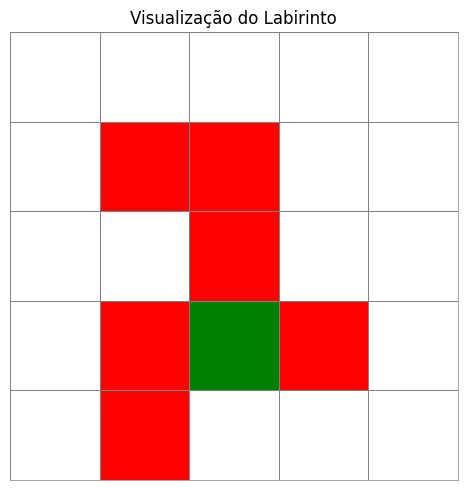

In [4]:
ambiente = AmbienteNavegacaoLabirinto(
        world_size=(5, 5),
        bad_states=[(1, 1), (1, 2), (2, 2), (3, 1), (3, 3), (4, 1)],
        target_states=[(3, 2)],
        allow_bad_entry=True,
        rewards=[-1, -10, 1, 0]
    )
ambiente.plot_labirinto()

## Iteração de valor

In [5]:
def iteracao_de_valor(
    ambiente: "AmbienteNavegacaoLabirinto",
    gamma: float = 0.9,
    theta: float = 1e-6,
    max_iteracoes: int = 1000,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, int]:
    """
    Implementa o algoritmo de Iteração de Valor com atualização síncrona (Jacobi) para encontrar a política ótima.
    Usa os modelos probabilísticos p(r|s,a) e p(s'|s,a) fornecidos pelo ambiente.

    Parameters
    ----------
    ambiente : AmbienteNavegacaoLabirinto
        Ambiente tabular que expõe:
        - n_states (int), n_actions (int)
        - state_transition_probabilities : ndarray, shape (n_states', n_states, n_actions)
          Probabilidade de transição p(s'|s,a) com eixo 0 = s', 1 = s, 2 = a.
        - reward_probabilities : ndarray, shape (n_rewards, n_states, n_actions)
          Probabilidade de recompensa p(r|s,a) com eixo 0 = r, 1 = s, 2 = a.
        - recompensas_possiveis : ndarray, shape (n_rewards,)
          Suporte ordenado dos valores de recompensa.
    gamma : float, default=0.9
        Fator de desconto. Em horizonte infinito sem estados terminais, recomenda-se 0 <= gamma < 1 para convergência.
    theta : float, default=1e-6
        Tolerância de convergência na norma infinita aplicada a ||v_{k+1} - v_k||.
    max_iteracoes : int, default=1000
        Número máximo de iterações.

    Returns
    -------
    V : ndarray, shape (n_states,)
        Valor de estado.
    Q : ndarray, shape (n_states, n_actions)
        Valores de ação calculados na última iteração.
    Pi : ndarray, shape (n_states, n_actions)
        Política gulosa determinística.
    num_iter : int
        Número de iterações efetivamente realizadas.
    """
    if not (0.0 <= gamma < 1.0):
        raise ValueError("Sem estados terminais, use 0 <= gamma < 1 para garantir convergência.")

    # Atalhos (utilize as variáveis que forem necessárias)
    n_estados       = ambiente.n_states
    n_acoes         = ambiente.n_actions
    n_recompensas   = ambiente.n_rewards
    R = ambiente.recompensas_imediatas              # r(s,a) -> r
    T = ambiente.transicao_de_estados               # T(s,a) -> s'
    Ps = ambiente.state_transition_probabilities    # shape (n_estados, n_estados, n_acoes)
    Pr = ambiente.reward_probabilities              # shape (n_recompensas,  n_estados, n_acoes)
    r_vector  = ambiente.recompensas_possiveis      # shape (n_recompensas,)

    # TODO: inicialize V, Q, Pi
    for k in range(max_iteracoes):
        # TODO: armazenar V_old
        # TODO: laços sobre estados e ações
        # TODO: atualizar Q, Pi e V
        # TODO: critério de parada
        pass
    # TODO: retorne V, Q, Pi, k+1
    raise NotImplementedError

## Experimento

### Simulação

In [6]:
V, Q, Pi, k = iteracao_de_valor(ambiente,           # gridworld
                                gamma=0.9,          # fator de desconto (0 <= gamma < 1)
                                theta=1e-6,         # tolerância de convergência (norma infinita ||v_{k+1} - v_k||_inf)
                                max_iteracoes=1000  # número máximo de iterações
                                )

NotImplementedError: 

### Visualização

In [ ]:
# Q: ndarray (n_estados, n_acoes)
plot_tabular(Q, kind="Q")

# Pi: ndarray (n_estados, n_acoes)
plot_tabular(Pi, kind="Pi")

# V: ndarray (n_estados,)
plot_tabular(V, kind="V", ambiente=ambiente, center_zero=False)

# Política (setas) sobre o ambiente
_ = plot_policy(ambiente, Pi)

# Tarefa:

1. Variação do fator de desconto
- Observar e reportar o efeito de diferentes valores da taxa de desconto (por exemplo: $\gamma \in \{\,0.0,\ 0.5,\ 0.9\,\}$)
2. Penalidade de estados ruins mais branda
- Observar e reportar o efeito de trocar $r_{\text{bad}}=-10$ para $r_{\text{bad}}=-1$.
3. Transformação afim nas recompensas
- Observar e reportar o efeito de uma transformação afim ($r' = a\,r + b$, com $a>0$) em todas as recompensas, isto é, em todos os elementos de $[\,r_{\text{boundary}}, r_{\text{bad}}, r_{\text{target}}, r_{\text{other}}\,]$.

**Configuração base (baseline)**

- `world_size = (5, 5)`
- `target_states = [(3, 2)]`
- `bad_states = [(1, 1), (1, 2), (2, 2), (3, 1), (3, 3), (4, 1)]`
- `allow_bad_entry = True`
- recompensas base: $[\,r_{\text{boundary}},\ r_{\text{bad}},\ r_{\text{target}},\ r_{\text{other}}\,] = [-1,\ -10,\ 1,\ 0]$
- tolerância e limite: $\theta = 10^{-6}$, `max_iteracoes = 1000`

> Se alterar qualquer parâmetro do setup, **documente explicitamente** no relatório.

**Em todos os experimentos mostrar:**

1. **Figuras**:
   - heatmap de $V(s)$ no grid $(n_{\text{rows}}\times n_{\text{cols}})$;
   - heatmap de $Q(s,a)$ (ações nas linhas, estados nas colunas);
   - heatmap de $\pi(a\mid s)$ (probabilidades).
2. **Convergência**: número de iterações até $\lVert v_{k+1}-v_k\rVert_\infty < \theta$.
3. **Discussão**: texto breve (3–6 linhas) por experimento.

**Entregáveis:**

2. **Código** (notebook `.ipynb`)
1. **Relatório** (`.pdf`).
- O PDF deve conter:
  - **Setup** (parâmetros usados).
  - **Resultados** (figuras e tabelas organizadas por experimento).
  - **Análises curtas** por experimento.
- O PDF **NÃO** deve conter:
    - Códigos.